# How good are language models we use for Style Transfer?

Let's load pretrained language models on sentiment data. We will test both yelp and sentiment treebank language models. 

In [20]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from tqdm.auto import tqdm

plt.style.use('fivethirtyeight')

In [22]:
from style_transfer import Tokenizer, get_dataset, translate
sys.path.append('../deep-latent-sequence-model/src')
from lm_lstm import LSTM_LM

device = torch.device('cpu')
model_dir = '../deep-latent-sequence-model/pretrained_lm/sentiment_style0'
model_path = os.path.join(model_dir, 'model.pt')
model = torch.load(model_path).eval().to(device)

vocab_path = 'data/sentiment/text.vocab'
with open(vocab_path) as f:
    vocab = [word.strip() for word in f.readlines()]
tokenizer = Tokenizer(vocab)

In [23]:
model

LSTM_LM(
  (embed): Embedding(9365, 128, padding_idx=0)
  (dropout_in): Dropout(p=0.3, inplace=False)
  (dropout_out): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 512, batch_first=True)
  (pred_linear): Linear(in_features=512, out_features=9365, bias=True)
  (loss): CrossEntropyLoss()
)

## Predicting next word given a sequence of words 

In [24]:
x = torch.tensor([[1, 2, 3]])
x_len = torch.tensor([3])
print(model.log_probability(x, x_len))
logits = model.decode(x, x_len)  # (batch_size, seq_len, vocab_size)
output_logits = logits[0, -1, :]
output_logits.shape

tensor([-2.8521], grad_fn=<NegBackward>)


torch.Size([9365])

In [25]:
predicted_words = output_logits.argmax()
predicted_words

tensor(40, grad_fn=<NotImplemented>)

In [26]:
tokenizer.decode(6904)

'ricky'

## Deterministic sequence generation given initial word

In [7]:
tokenizer.tokenize('i')

[4091]

Single next word to see if this works.

In [8]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = next_word_logits.argmax().item()
predicted_token, tokenizer.decode(predicted_token)

(3297, 'food')

Generating sequence of words.

In [9]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
i = 0
while words[-1] != '<num>' and words[-1] != '<unk>' and words[-1] != '.':
    x = torch.tensor([tokens])
    x_len = [len(tokens)]
    next_word_logits = model.decode(x, x_len)[0, -1, :]
    predicted_token = next_word_logits.argmax().item()
    tokens.append(predicted_token)
    words.append(tokenizer.decode(predicted_token))
' '.join(words)

'The food was great .'

In [10]:
def generate_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    i = 0
    while words[-1] != '.':
        i += 1
        if i > 15:
            break
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = next_word_logits.argmax().item()
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)

In [11]:
print(generate_sequence_from(["The"]))
print(generate_sequence_from(["The place"]))
print(generate_sequence_from(["I"]))
print(generate_sequence_from(["We"]))
print(generate_sequence_from(["What"]))
print(generate_sequence_from(["Well"]))
print(generate_sequence_from(["Do"]))
print(generate_sequence_from(["Hmm"]))
print(generate_sequence_from(["Possibly"]))
print(generate_sequence_from(["Not"]))
print(generate_sequence_from(["I would"]))
print(generate_sequence_from(["The restaurant"]))

The food was great .
The place food was great .
I was very disappointed .
We had a great time .
What i got was a great experience .
Well .
Do n't go there .
Hmm .
Possibly the best in town .
Not a good sign .
I would was very disappointed .
The restaurant food was great .


The language model we trained is not of the best quality unfortunately. If language model doesn't work well, we can't really expect final style transfer model to work well, since it is a prior in our model.

I think it is crucial to have good language model. Maybe Bert with WordPiece tokenization will improve things.

## Random sampling of words with logits probability

In [12]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
predicted_token, tokenizer.decode(predicted_token)

(6983, 'rooftop')

The most probable words after 'the'.

In [13]:
def most_probable(next_word_logits, k=10):
    word_probs = list(zip(vocab, next_word_logits.softmax(0).detach().numpy()))
    return sorted(word_probs, key=lambda t: t[1], reverse=True)[:k]
most_probable(next_word_logits, k=15)

[('food', 0.07363897),
 ('best', 0.03956124),
 ('service', 0.038740963),
 ('place', 0.02569076),
 ('staff', 0.021668633),
 ('other', 0.013282112),
 ('first', 0.012337483),
 ('restaurant', 0.010821961),
 ('price', 0.010469027),
 ('next', 0.010369063),
 ('whole', 0.009594001),
 ('worst', 0.009499044),
 ('most', 0.0091636125),
 ('same', 0.008161825),
 ('owner', 0.007962195)]

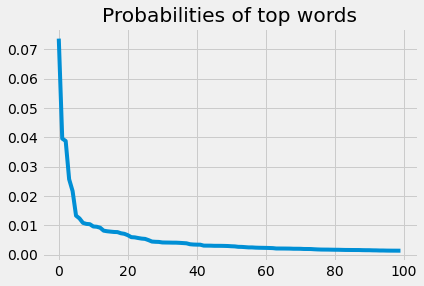

In [14]:
probs = next_word_logits.softmax(0).detach().numpy()
sorted_word_probs = sorted(probs, reverse=True)
plt.plot(sorted_word_probs[:100])
plt.title('Probabilities of top words');

In [15]:
tokenizer.tokenize('<pad>')

[0]

In [16]:
tokenizer.decode(0), tokenizer.decode(1)

('<pad>', '<unk>')

I just realized, that in my vocab I forgot to put \<pad\> and \<unk\> tokens! This means that my models might not work properly, and this can be the reason for poor performance of my style transfer experiments.

EDIT: solved now

In [19]:
random.seed(1)
def generate_random_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    while words[-1] != '.' and words[-1] != '<pad>':
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)
for _ in range(30):
    print(generate_random_sequence_from(["The"]))

The cake was quite filling .
The lady that work here ! # _num_ is _num_ .
The restaurant called until today ! # _num_ was horrible .
The hummus ( by far ) .
The drive-thru .
The latter .
The ambiance the other option .
The worst service and food i have experienced .
The side of ingredients has really improved .
The other .
The enormous selection for breakfast .
The quality of the food .
The serious manager .
The manager 's .
The quality was not good .
The menu wins nothing like this .
The moment you walk in .
The nicest too ! # _num_ the ribs were last night .
The bathroom was n't clean .
The manager came home and rushed away .
The area and enjoy the staff .
The service was fairly slow .
The best ! # _num_ .
The bill is as a buffet .
The coaches are rude .
The food is absolutely delicious .
The croissants .
The tea is awesome .
The service , although i was disappointed .
The price is faster to prepare .


Interesting fact: when you use a token that never occurs, the RNN can predict it as a possible output. In fact it does it quite often. When unknown token is put into the model, the model doesn't know what to do, the logits can become big since the embedding of the unknown token wasn't optimized at all.

EDIT: Solved

After using _num_ token to replace every number, it is predicted way too often ("The room so we bought it ! # \_num\_ ! # \_num\_ i enjoyed one other ! # \_num\_ a \_num\_ wheel .", "The dog and ray 's are always great ! # \_num\_ ! # \_num\_ .". 

EDIT: solved, I do not use \_num\_ token that often now (I replace words consisting of only digits and dots/commas with \_num\_). I have to be careful not to replace dots with \_num\_. 